In [1]:
# 安装必要库
%pip install holidays xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import holidays
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [30]:
# Step 1: 模拟数据生成
np.random.seed(42)
dates = pd.date_range(start="2022-01-01", end="2024-12-31", freq="B")  # 仅生成工作日
data = pd.DataFrame({
    "date": dates,
    "in": np.random.normal(500, 50, len(dates)),  # 平时波动的申购额
    "out": np.random.normal(300, 30, len(dates)),  # 平时波动的赎回额
})

# 模拟节假日前后 1 天数据的剧烈波动
# 添加往年节假日
cn_holidays_2021 = holidays.China(years=[2021])
cn_holidays_2022 = holidays.China(years=[2022])
cn_holidays_2023 = holidays.China(years=[2023])
cn_holidays_2024 = holidays.China(years=[2024])

all_holidays = list(cn_holidays_2021) + list(cn_holidays_2022) + list(cn_holidays_2023) + list(cn_holidays_2024)
data["is_holiday"] = data["date"].isin(all_holidays)  # 标记是否为节假日
data["is_pre_holiday"] = data["date"].shift(-1).isin(all_holidays)  # 标记是否为节假日前一天
data["is_post_holiday"] = data["date"].shift(1).isin(all_holidays)  # 标记是否为节后一天

# 模拟节假日前后 1 天数据的剧烈波动
for holiday_date in all_holidays:
    if holiday_date in dates:
        # 节假日当天及其前后数据大幅波动
        data.loc[data["date"] == holiday_date, "in"] += np.random.randint(800, 1500)
        data.loc[data["date"] == holiday_date, "out"] += np.random.randint(800, 1500)
        # 节假日前一天和节后一天数据大幅波动
        data.loc[data["is_pre_holiday"] == True, "in"] += np.random.randint(500, 1000)
        data.loc[data["is_post_holiday"] == True, "in"] += np.random.randint(500, 1000)
        data.loc[data["is_pre_holiday"] == True, "out"] += np.random.randint(500, 1000)
        data.loc[data["is_post_holiday"] == True, "out"] += np.random.randint(500, 1000)

C:\Users\wuwenbo\AppData\Local\Temp\ipykernel_53104\3079933196.py:18: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data["is_holiday"] = data["date"].isin(all_holidays)  # 标记是否为节假日
C:\Users\wuwenbo\AppData\Local\Temp\ipykernel_53104\3079933196.py:19: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data["is_pre_holiday"] = data["date"].shift(-1).isin(all_holidays)  # 标记是否为节假日前一天
C:\Users\wuwenbo\AppData\Local\Temp\ipykernel_53104\3079933196.py:20: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, 

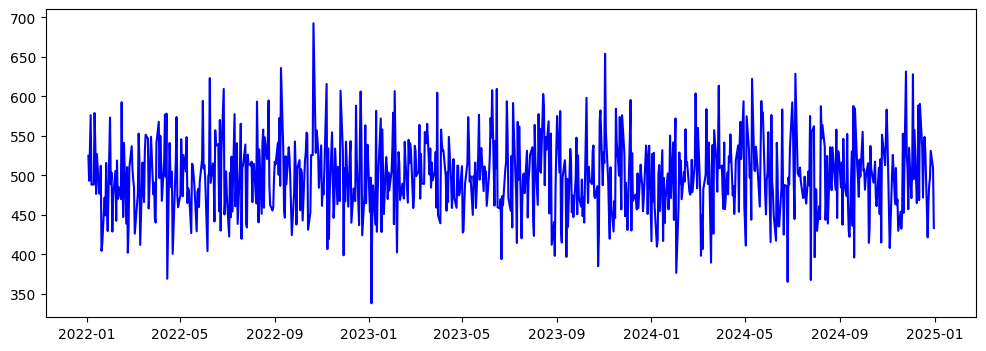

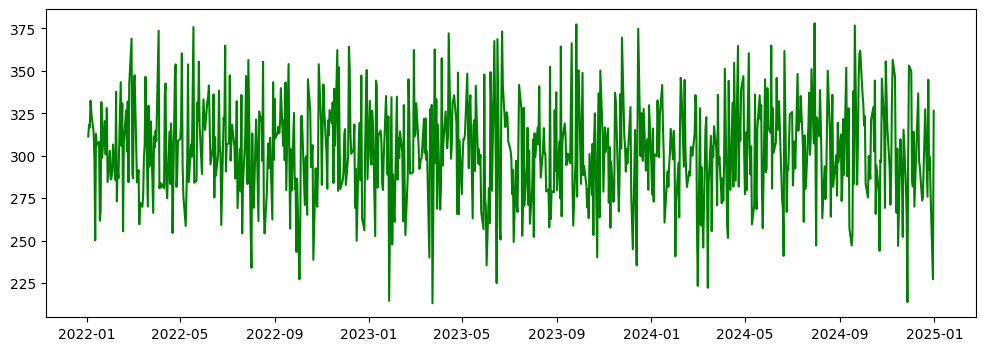

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(data.set_index('date')['in'], label='in', color='blue')

plt.figure(figsize=(12, 4))
plt.plot(data.set_index('date')['out'], label='out', color='green')

In [38]:
# Step 2: 确定目标节假日
current_year_holidays = holidays.China(years=[2023])  # 当前年的节假日

In [33]:
# Step 3: 加入往年节假日对应工作日的销量比值特征
def calculate_holiday_ratio(data, holiday_dates, feature_col="in", weights=None):
    """
    计算节假日与往年节假日销量的加权比值特征
    """
    if weights is None:
        weights = [0.35, 0.35, 0.15, 0.15]  # 默认权重分配

    # 初始化特征列
    data[f"{feature_col}_holiday_ratio_feature"] = 0.0

    for holiday_date in holiday_dates:
        if holiday_date in data["date"].values:
            # 找到节假日前后两周的对应日期（假设是工作日对齐）
            idx = data[data["date"] == holiday_date].index[0]

            # 往年对应的关键日期
            key_dates = [
                holiday_date - pd.Timedelta(days=7),  # 前一周同一天
                holiday_date + pd.Timedelta(days=7),  # 后一周同一天
                holiday_date - pd.Timedelta(days=14), # 前两周同一天
                holiday_date + pd.Timedelta(days=14), # 后两周同一天
            ]

            # 遍历关键日期，计算加权平均销量
            weighted_sum = 0
            total_weight = 0
            for i, key_date in enumerate(key_dates):
                if key_date in data["date"].values:
                    key_value = data.loc[data["date"] == key_date, feature_col].values[0]
                    weighted_sum += key_value * weights[i]
                    total_weight += weights[i]

            # 当前节假日销量
            holiday_value = data.loc[data["date"] == holiday_date, feature_col].values[0]

            # 计算加权比值特征
            if total_weight > 0:
                ratio = holiday_value / (weighted_sum / total_weight)
                data.loc[data["date"] == holiday_date, f"{feature_col}_holiday_ratio_feature"] = ratio

    return data

In [34]:
# 计算节假日比值特征（针对申购额）
data = calculate_holiday_ratio(data, holiday_dates=current_year_holidays, feature_col="in")
# 计算节假日比值特征（针对赎回额）
data = calculate_holiday_ratio(data, holiday_dates=current_year_holidays, feature_col="out")


In [37]:
data[data['is_pre_holiday']==True]

,date,in,out,is_holiday,is_pre_holiday,is_post_holiday,holiday_ratio_feature
19,2022-01-28,429.384815,284.518658,False,True,False,0.0
20,2022-01-31,573.282438,302.883623,True,True,False,0.0
21,2022-02-01,488.711185,286.131741,True,True,True,0.0
22,2022-02-02,503.376410,286.965113,True,True,True,0.0
23,2022-02-03,428.762591,290.724836,True,True,True,0.0
64,2022-04-01,540.626291,308.675059,False,True,False,0.0
65,2022-04-04,567.812001,373.659004,True,True,False,0.0
84,2022-04-29,459.575320,308.575962,False,True,False,0.0
85,2022-05-02,474.912148,310.033704,True,True,False,0.0
86,2022-05-03,545.770106,319.756328,True,True,True,0.0


In [5]:
# Step 2: 使用 holidays 自动捕捉节日信息
# 添加往年节假日
cn_holidays_2021 = holidays.China(years=[2021])
cn_holidays_2022 = holidays.China(years=[2022])
cn_holidays_2023 = holidays.China(years=[2023])
# 指定国家（中国）
cn_holidays = holidays.China(years=[2024])  # 自动生成2022和2023年的节日

# 添加节日标记
data["is_holiday"] = data["date"].isin(cn_holidays)

# 添加节日前一天标记
data["is_pre_holiday"] = data["date"].shift(-1).isin(cn_holidays)

# 添加节日后一天标记
data["is_post_holiday"] = data["date"].shift(1).isin(cn_holidays)

# Step 3: 构造目标 - 节假日前后 1 天的数据
data["is_target"] = data["is_pre_holiday"] | data["is_post_holiday"]

# 将目标值单独保存
target_data = data[data["is_target"]].copy()


C:\Users\wuwenbo\AppData\Local\Temp\ipykernel_53104\2651977344.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data["is_holiday"] = data["date"].isin(cn_holidays)
C:\Users\wuwenbo\AppData\Local\Temp\ipykernel_53104\2651977344.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data["is_pre_holiday"] = data["date"].shift(-1).isin(cn_holidays)
C:\Users\wuwenbo\AppData\Local\Temp\ipykernel_53104\2651977344.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered ma

In [6]:
data.head()

,date,in,out,is_holiday,is_pre_holiday,is_post_holiday,is_target
0,2022-01-03,524.835708,272.192086,True,False,False,False
1,2022-01-04,493.086785,298.214239,False,False,True,True
2,2022-01-05,532.384427,202.761980,False,False,False,False
3,2022-01-06,576.151493,269.268371,False,False,False,False
4,2022-01-07,488.292331,292.422955,False,False,False,False


In [7]:
# Step 3: 特征工程
data["day_of_week"] = data["date"].dt.dayofweek  # 周几（0-6）
data["month"] = data["date"].dt.month  # 月份

# 构造滞后特征
for lag in range(1, 15):  # 滞后 1 到 14 天的数据
    data[f"purchase_lag_{lag}"] = data["in"].shift(lag)
    data[f"redemption_lag_{lag}"] = data["out"].shift(lag)

# 删除因滞后特征产生的空值
data = data.dropna()

# 对应地，目标特征需要调整
target_data = data[data["is_target"]]


In [8]:
data.head()

,date,in,out,is_holiday,is_pre_holiday,is_post_holiday,is_target,day_of_week,month,purchase_lag_1,...,purchase_lag_10,redemption_lag_10,purchase_lag_11,redemption_lag_11,purchase_lag_12,redemption_lag_12,purchase_lag_13,redemption_lag_13,purchase_lag_14,redemption_lag_14
14,2022-01-21,413.754108,270.554740,False,False,False,False,4,1,404.335988,...,488.292331,292.422955,576.151493,269.268371,532.384427,202.761980,493.086785,298.214239,524.835708,272.192086
15,2022-01-24,471.885624,313.863104,False,False,False,False,0,1,413.754108,...,488.293152,262.566505,488.292331,292.422955,576.151493,269.268371,532.384427,202.761980,493.086785,298.214239
16,2022-01-25,449.358444,305.971791,False,False,False,False,1,1,471.885624,...,578.960641,348.972339,488.293152,262.566505,488.292331,292.422955,576.151493,269.268371,532.384427,202.761980
17,2022-01-26,515.712367,281.993494,False,False,False,False,2,1,449.358444,...,538.371736,257.095759,578.960641,348.972339,488.293152,262.566505,488.292331,292.422955,576.151493,269.268371
18,2022-01-27,454.598796,302.094063,False,False,False,False,3,1,515.712367,...,476.526281,286.798665,538.371736,257.095759,578.960641,348.972339,488.293152,262.566505,488.292331,292.422955


In [9]:
# Step 4: 构造训练集和测试集
features = [col for col in data.columns if col not in ["date", "in", "out"]]
X = data[features]
y_purchase = data["in"]
y_redemption = data["out"]

X_train, X_test, y_train_purchase, y_test_purchase = train_test_split(X, y_purchase, test_size=0.2, random_state=42)
X_train, X_test, y_train_redemption, y_test_redemption = train_test_split(X, y_redemption, test_size=0.2, random_state=42)

In [10]:
# Step 5: 模型训练
purchase_model = XGBRegressor(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=500,
    reg_alpha=10,
    gamma=1,
    random_state=42,
    objective='reg:squarederror'
)
redemption_model = XGBRegressor(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=500,
    reg_alpha=10,
    gamma=1,
    random_state=42
)

purchase_model.fit(X_train, y_train_purchase)
redemption_model.fit(X_train, y_train_redemption)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [11]:
# Step 6: 模型预测
y_pred_purchase = purchase_model.predict(X_test)
y_pred_redemption = redemption_model.predict(X_test)

# Step 7: 评估模型
purchase_rmse = np.sqrt(mean_squared_error(y_test_purchase, y_pred_purchase))
redemption_rmse = np.sqrt(mean_squared_error(y_test_redemption, y_pred_redemption))

print(f"申购额预测 RMSE: {purchase_rmse}")
print(f"赎回额预测 RMSE: {redemption_rmse}")

申购额预测 RMSE: 60.92616173854859
赎回额预测 RMSE: 31.2435200579824


C:\Users\wuwenbo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30003 (\N{CJK UNIFIED IDEOGRAPH-7533}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wuwenbo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36141 (\N{CJK UNIFIED IDEOGRAPH-8D2D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wuwenbo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wuwenbo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wuwenbo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pyl

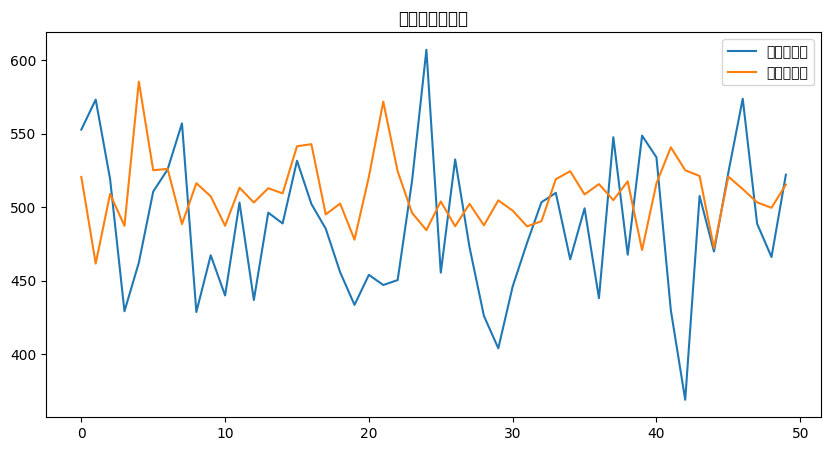

C:\Users\wuwenbo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36174 (\N{CJK UNIFIED IDEOGRAPH-8D4E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wuwenbo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


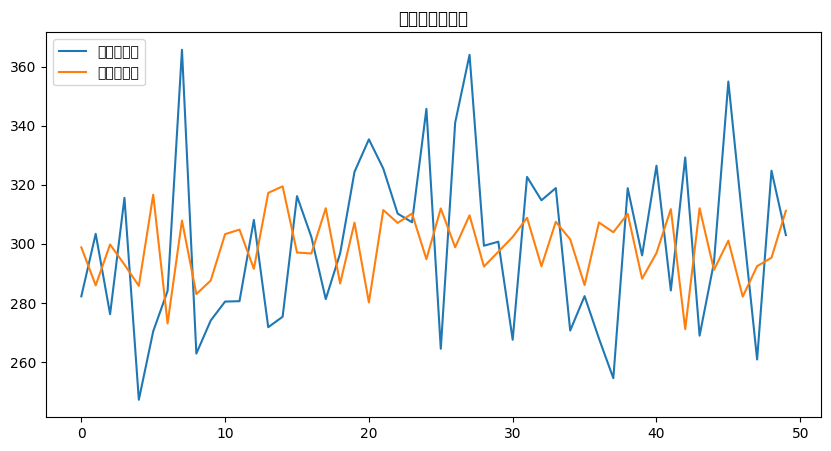

In [12]:
# Step 8: 可视化结果
plt.figure(figsize=(10, 5))
plt.plot(y_test_purchase.values, label="实际申购额")
plt.plot(y_pred_purchase, label="预测申购额")
plt.legend()
plt.title("申购额预测结果")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_redemption.values, label="实际赎回额")
plt.plot(y_pred_redemption, label="预测赎回额")
plt.legend()
plt.title("赎回额预测结果")
plt.show()
